In [1]:
import numpy as np
import tqdm
import os
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
import cv2
import sys
sys.path.append("/home/alexeygrigoriev/Projects/TD/Metrics/lib/")
from glob import glob
from utils import CoordinatesType, BBType, BBFormat, MethodAveragePrecision
from BoundingBox import BoundingBox
from Evaluator import Evaluator
from BoundingBoxes import BoundingBoxes

In [2]:
def getBoundingBoxes(gt_directory, pred_directory, confidence_threshold=0.9, CLEAN_DATA=False):
    """
    auxiliary function for evaluation
    params:
    gt_directory: str, path to groud truth boxes
    pred_directory: str, path to prediction boxes
    
    return: class, auxiliary class
    """
    allBoundingBoxes = BoundingBoxes()
    import glob
    import os
    folderGT = gt_directory
    
    ####################################################################
    if CLEAN_DATA:
        cleanDir = '/home/alexeygrigoriev/Projects/TD/data_dir/test_images/TableBank/checked_gt_images/'
        os.chdir(cleanDir)
        files = [x[:-3]+'txt' for x in glob.glob("*.jpg")]
        files.sort()
    else:
        os.chdir(folderGT)
        files = glob.glob("*.txt")
        files.sort()
        
    os.chdir(folderGT)
    allBoundingBoxes = BoundingBoxes()
    # Read GT detections from txt file
    # Each line of the files in the groundtruths folder represents a ground truth bounding box
    # (bounding boxes that a detector should detect)
    # Each value of each line is  "class_id, x, y, width, height" respectively
    # Class_id represents the class of the bounding box
    # x, y represents the most top-left coordinates of the bounding box
    # x2, y2 represents the most bottom-right coordinates of the bounding box
    for f in files:
        nameOfImage = f.replace(".txt", "")
        fh1 = open(f, "r")
        for line in fh1:
            line = line.replace("\n", "")
            if line.replace(' ', '') == '':
                continue
            splitLine = line.split(" ")
            idClass = splitLine[0]  # class
            x = float(splitLine[1])  # confidence
            y = float(splitLine[2])
            x2 = float(splitLine[3])
            y2 = float(splitLine[4])
            bb = BoundingBox(
                nameOfImage,
                idClass,
                x,
                y,
                x2,
                y2,
                CoordinatesType.Absolute, None,
                BBType.GroundTruth,
                format=BBFormat.XYX2Y2)
            allBoundingBoxes.addBoundingBox(bb)
        fh1.close()
    # Read detections
    folderDet = pred_directory# os.path.join(currentPath, 'detections')
    os.chdir(folderDet)
    
    if not CLEAN_DATA:
        files = glob.glob("*.txt")
        files.sort()
    # Read detections from txt file
    # Each line of the files in the detections folder represents a detected bounding box.
    # Each value of each line is  "class_id, confidence, x, y, width, height" respectively
    # Class_id represents the class of the detected bounding box
    # Confidence represents confidence (from 0 to 1) that this detection belongs to the class_id.
    # x, y represents the most top-left coordinates of the bounding box
    # x2, y2 represents the most bottom-right coordinates of the bounding box
    for f in files:
        # nameOfImage = f.replace("_det.txt","")
        nameOfImage = f.replace(".txt", "")
        # Read detections from txt file
        fh1 = open(f, "r")
        for line in fh1:
            line = line.replace("\n", "")
            if line.replace(' ', '') == '':
                continue
            splitLine = line.split(" ")
            idClass = splitLine[0]  # class
            confidence = float(splitLine[1])  # confidence
            x = float(splitLine[2])
            y = float(splitLine[3])
            x2 = float(splitLine[4])
            y2 = float(splitLine[5])
            if confidence > confidence_threshold:
                bb = BoundingBox(
                    nameOfImage,
                    idClass,
                    x,
                    y,
                    x2,
                    y2,
                    CoordinatesType.Absolute, None,
                    BBType.Detected,
                    confidence,
                    format=BBFormat.XYX2Y2)
                allBoundingBoxes.addBoundingBox(bb)
        fh1.close()
    return allBoundingBoxes

In [3]:
def get_metrics(metricsPerClass):
    """
    print object detection metrics
    params:
    metricsPerClass: class, auxiliary class
    
    result: None
    """
    result = []
    for mc in metricsPerClass:
        c = mc['class']
        precision = mc['precision']
        recall = mc['recall']
        average_precision = mc['AP']
        ipre = mc['interpolated precision']
        irec = mc['interpolated recall']
        total_positives = mc['total positives']
        total_TP = mc['total TP']
        total_FP =mc['total FP']
        #print('%s total_positives: %f' % (c, total_positives))
        #print('%s total_TP: %f' % (c, total_TP))
        #print('%s total_FP: %f' % (c, total_FP))
        Precision = total_TP/(total_TP+total_FP)
        print('Precision: {:.4f}'.format(Precision))
        Recall = total_TP/total_positives
        print('Recall: {:.4f}'.format(Recall))
        print('F: {:.4f}'.format(2*Recall*Precision/(Precision+Recall)))

In [4]:
def make_submit(predict_boxes=None, pred_directory='', gt_directory='', IOUThreshold=0.8,
               RETURN_ERRORS=True, FILTER=False, CLEAN_DATA=False):
    if predict_boxes is not None:
        predict_boxes = [converter(boxes) for boxes in predict_boxes]

        if not os.path.exists(pred_directory):
                    os.makedirs(pred_directory)

        save_resalts(predict_boxes,
                 directory=pred_directory,
                 prediction=True)
    boundingboxes = getBoundingBoxes(gt_directory, pred_directory, CLEAN_DATA=CLEAN_DATA)
    evaluator = Evaluator()
    metricsPerClass, fp_bboxes = evaluator.GetPascalVOCMetrics(
        boundingboxes,  # Object containing all bounding boxes (ground truths and detections)
        IOUThreshold=IOUThreshold,  
        method=MethodAveragePrecision.EveryPointInterpolation,
        RETURN_ERRORS=RETURN_ERRORS,
        FILTER=FILTER)
    dataset_name, model_name = pred_directory.split('/')[-3:-1] 
    print('result:', ' on ', dataset_name, 'IOUThreshold: ', IOUThreshold)
    get_metrics(metricsPerClass)
    return fp_bboxes

In [5]:
# MARMOT
# _ = make_submit(None, pred_directory='/home/alexeygrigoriev/Projects/TD/data_dir/test_images/Marmot/Detections/',
#            gt_directory='/home/alexeygrigoriev/Projects/TD/data_dir/test_images/Marmot/Ground_Truth/',
#            IOUThreshold=0.8)

In [6]:
# TableBank Raw
_ = make_submit(None, pred_directory='/home/alexeygrigoriev/Projects/TD/data_dir/test_images/TableBank/Detections/',
            gt_directory='/home/alexeygrigoriev/Projects/TD/data_dir/test_images/TableBank/Ground_Truth/',
            IOUThreshold=0.8,
            FILTER=False, CLEAN_DATA=True)
print('-'*50)
_ = make_submit(None, pred_directory='/home/alexeygrigoriev/Projects/TD/data_dir/test_images/TableBank/Detections/',
            gt_directory='/home/alexeygrigoriev/Projects/TD/data_dir/test_images/TableBank/Ground_Truth/',
            IOUThreshold=0.8,
            FILTER=True, CLEAN_DATA=True)

result:  on  TableBank IOUThreshold:  0.8
Precision: 0.9686
Recall: 0.9655
F: 0.9670
--------------------------------------------------
result:  on  TableBank IOUThreshold:  0.8
Precision: 0.9757
Recall: 0.9655
F: 0.9706


In [7]:
# TableBank Transformed

_ = make_submit(None, 
            pred_directory='/home/alexeygrigoriev/Projects/TD/data_dir/test_images/TableBank/dtrans_Detections/',
            gt_directory='/home/alexeygrigoriev/Projects/TD/data_dir/test_images/TableBank/Ground_Truth/',
            IOUThreshold=0.8,
            FILTER=False, CLEAN_DATA=True)
print('-'*50)
_ = make_submit(None, 
            pred_directory='/home/alexeygrigoriev/Projects/TD/data_dir/test_images/TableBank/dtrans_Detections/',
            gt_directory='/home/alexeygrigoriev/Projects/TD/data_dir/test_images/TableBank/Ground_Truth/',
            IOUThreshold=0.8,
            FILTER=True, CLEAN_DATA=True)

result:  on  TableBank IOUThreshold:  0.8
Precision: 0.9628
Recall: 0.9551
F: 0.9589
--------------------------------------------------
result:  on  TableBank IOUThreshold:  0.8
Precision: 0.9690
Recall: 0.9518
F: 0.9603


In [8]:
# TableBank Mixed
_ = make_submit(None, 
            pred_directory='/home/alexeygrigoriev/Projects/TD/data_dir/test_images/TableBank/mixed_Detections/',
            gt_directory='/home/alexeygrigoriev/Projects/TD/data_dir/test_images/TableBank/Ground_Truth/',
            IOUThreshold=0.8,
            FILTER=False, CLEAN_DATA=True)
print('-'*50)
fp_bboxes = make_submit(None, 
            pred_directory='/home/alexeygrigoriev/Projects/TD/data_dir/test_images/TableBank/mixed_Detections/',
            gt_directory='/home/alexeygrigoriev/Projects/TD/data_dir/test_images/TableBank/Ground_Truth/',
            IOUThreshold=0.8,
            FILTER=True, CLEAN_DATA=True)

result:  on  TableBank IOUThreshold:  0.8
Precision: 0.9743
Recall: 0.9719
F: 0.9731
--------------------------------------------------
result:  on  TableBank IOUThreshold:  0.8
Precision: 0.9845
Recall: 0.9703
F: 0.9774


In [9]:
# TableBank Mixed
_ = make_submit(None, 
            pred_directory='/home/alexeygrigoriev/Projects/TD/data_dir/test_images/TableBank/mixed_Detections_v2/',
            gt_directory='/home/alexeygrigoriev/Projects/TD/data_dir/test_images/TableBank/Ground_Truth/',
            IOUThreshold=0.8,
            FILTER=False, CLEAN_DATA=True)
print('-'*50)
fp_bboxes = make_submit(None, 
            pred_directory='/home/alexeygrigoriev/Projects/TD/data_dir/test_images/TableBank/mixed_Detections_v2/',
            gt_directory='/home/alexeygrigoriev/Projects/TD/data_dir/test_images/TableBank/Ground_Truth/',
            IOUThreshold=0.8,
            FILTER=True, CLEAN_DATA=True)

result:  on  TableBank IOUThreshold:  0.8
Precision: 0.9861
Recall: 0.9687
F: 0.9773
--------------------------------------------------
result:  on  TableBank IOUThreshold:  0.8
Precision: 0.9901
Recall: 0.9679
F: 0.9789


In [10]:
boundingboxes = getBoundingBoxes(pred_directory='/home/alexeygrigoriev/Projects/TD/data_dir/test_images/TableBank/mixed_Detections_v2/',
            gt_directory='/home/alexeygrigoriev/Projects/TD/data_dir/test_images/TableBank/Ground_Truth/')

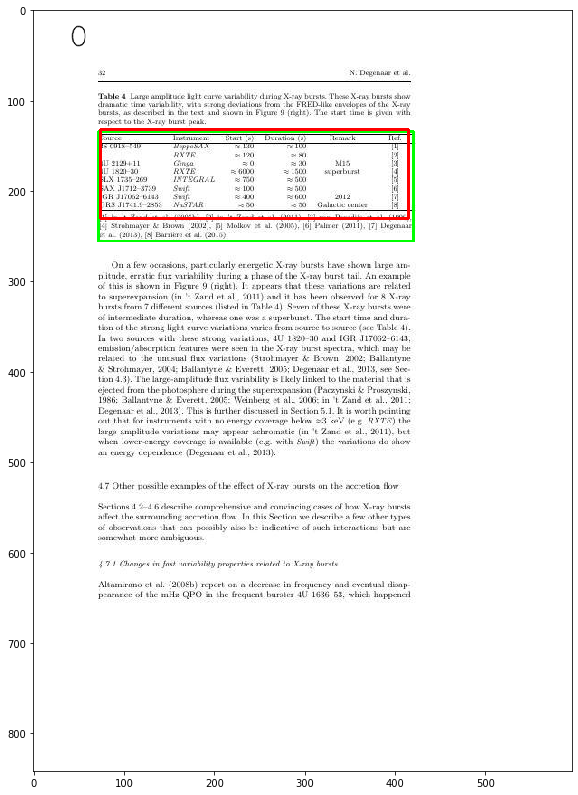

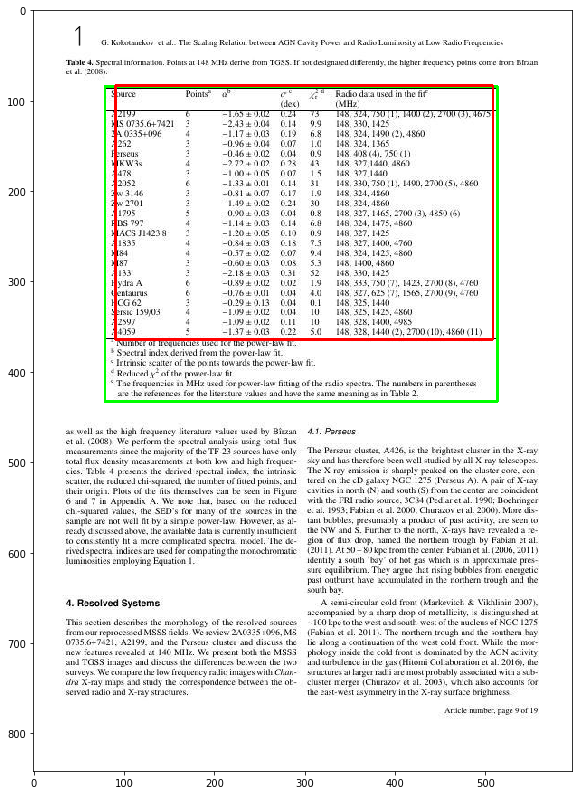

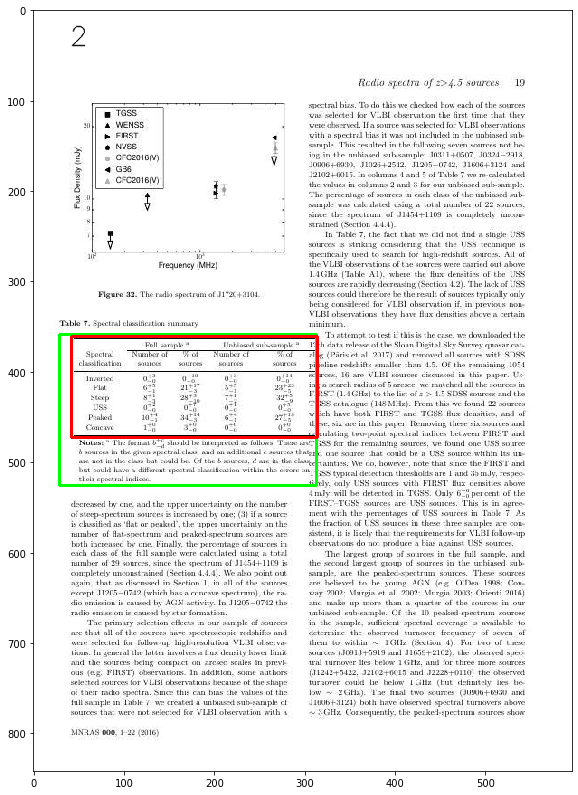

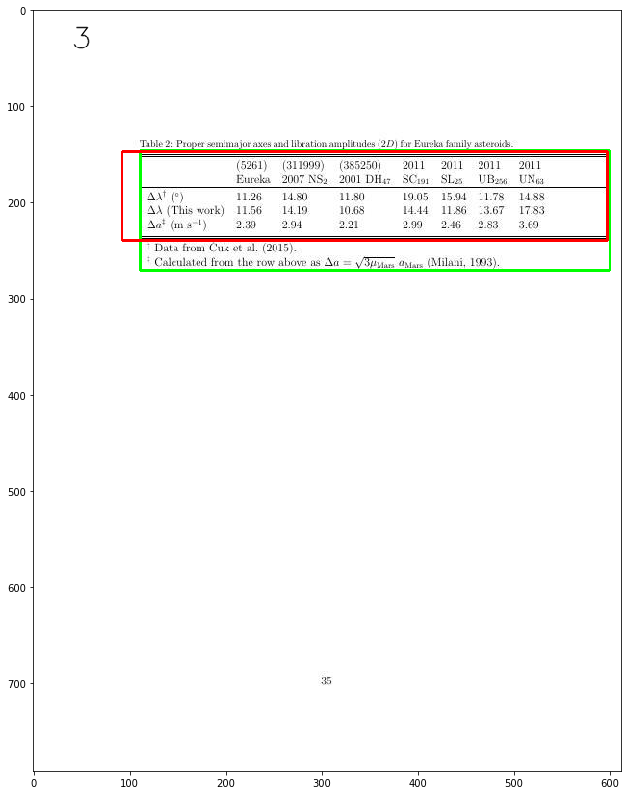

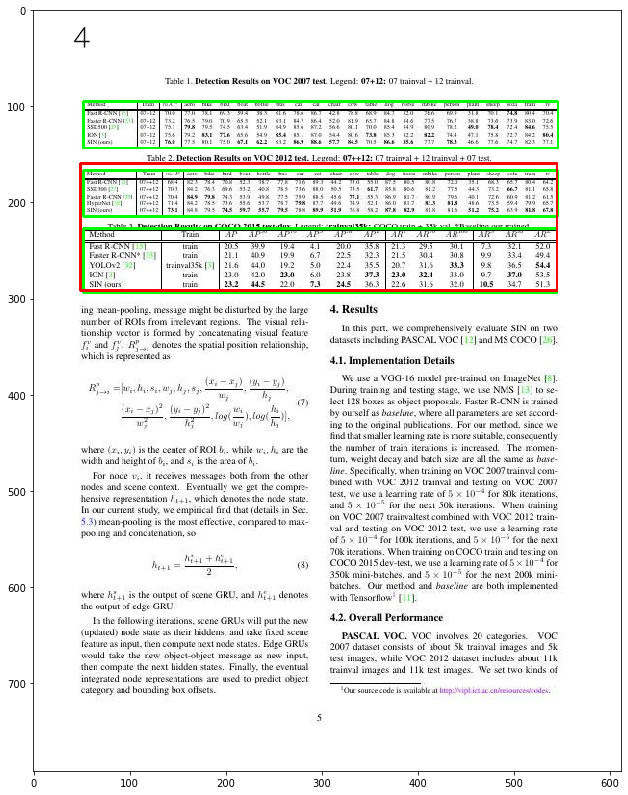

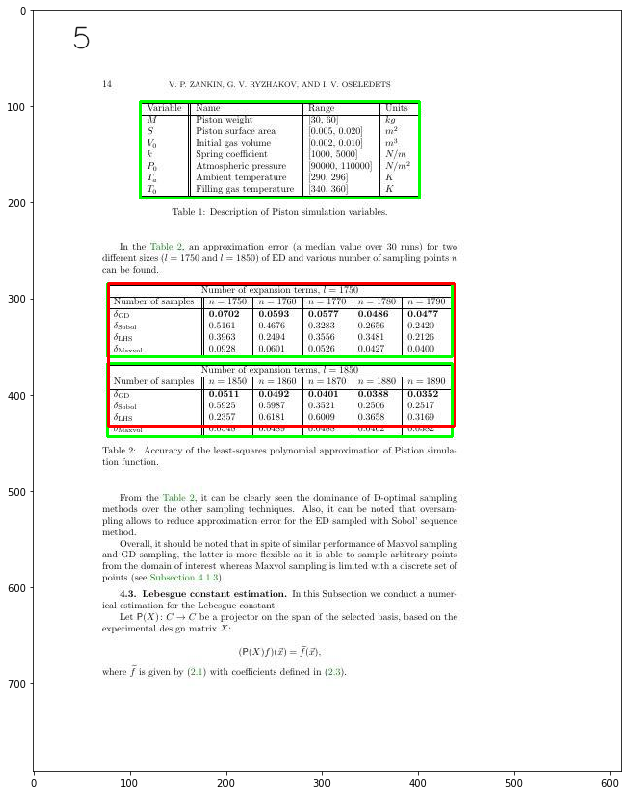

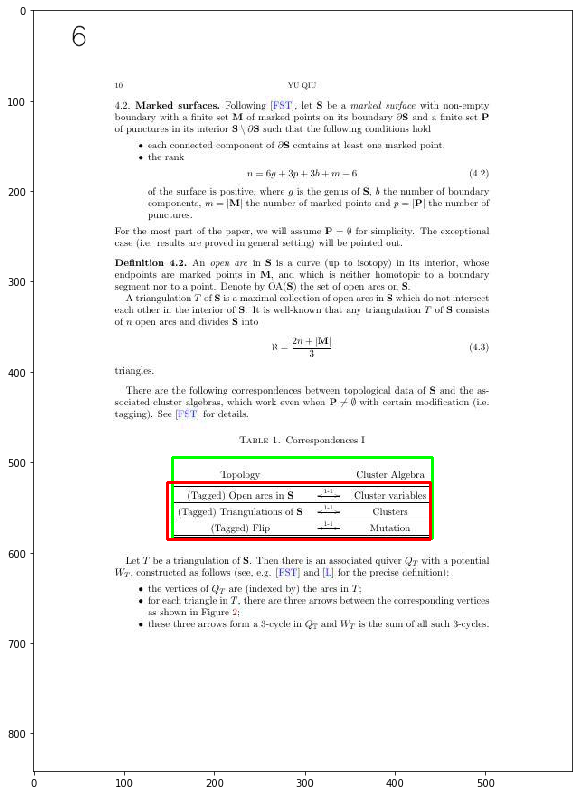

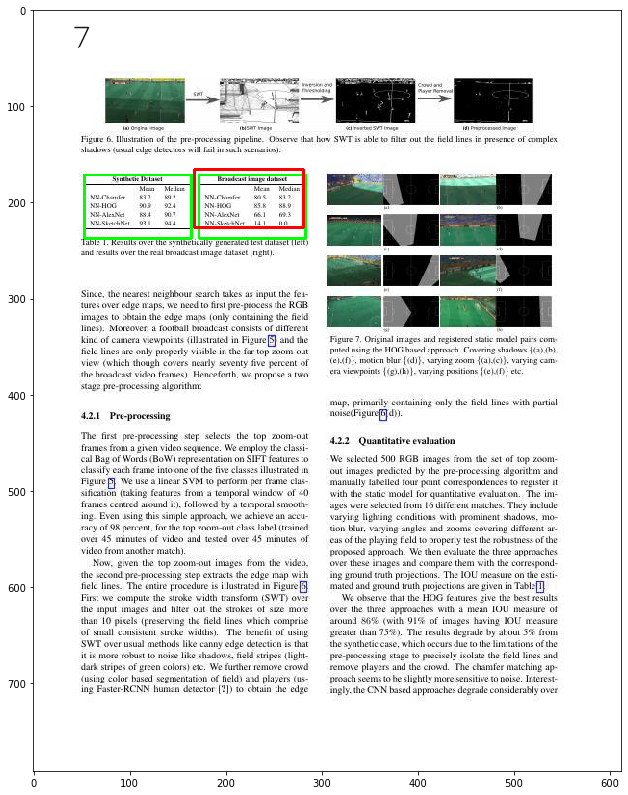

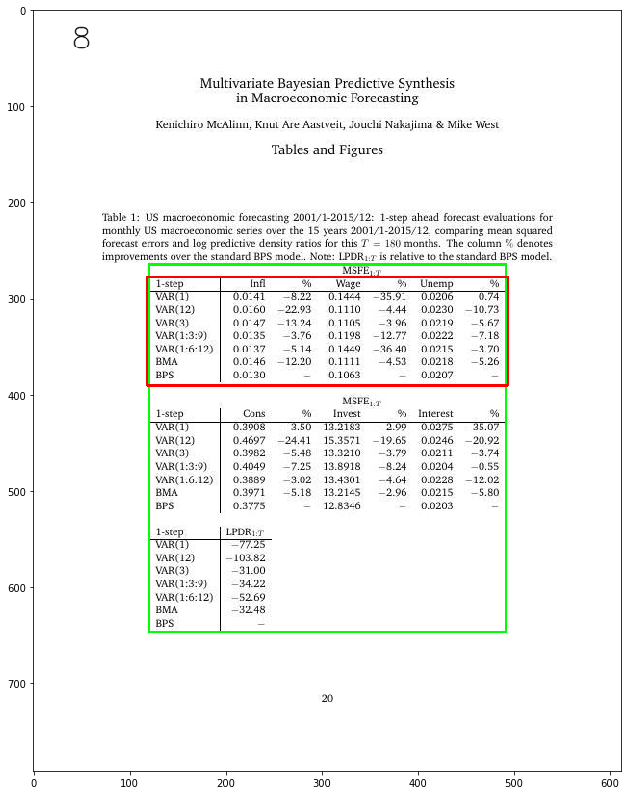

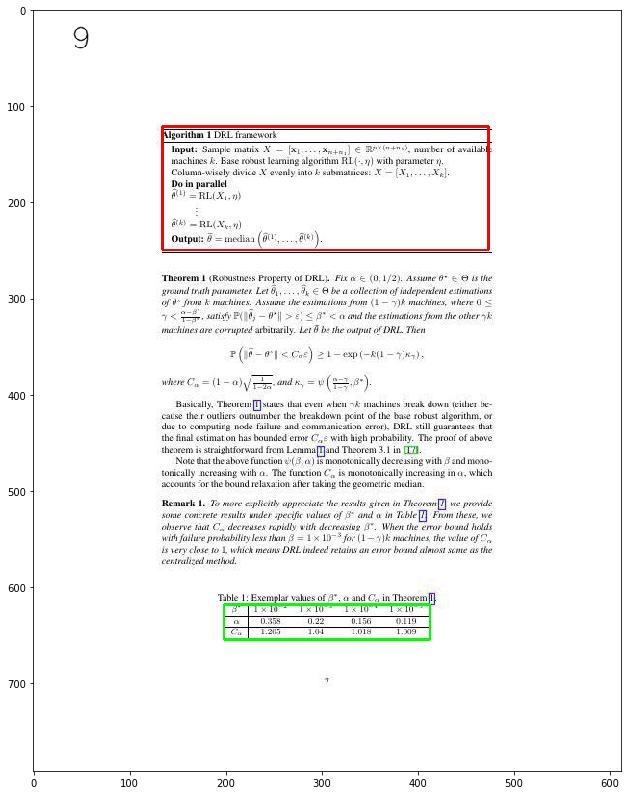

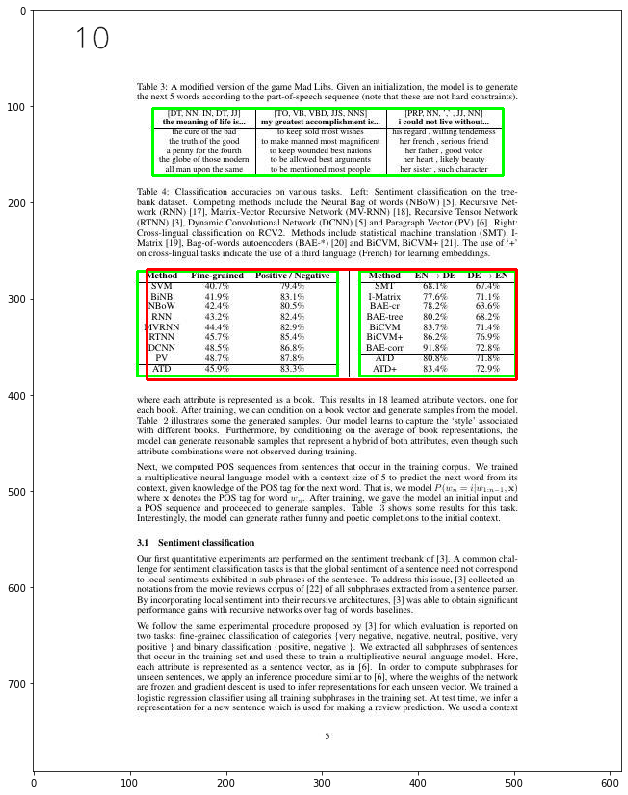

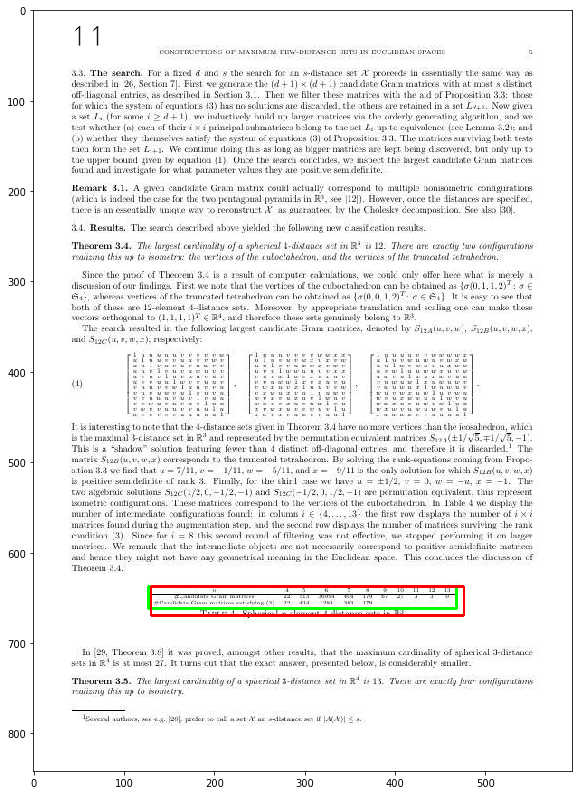

In [11]:
# analysis of FP
fp_images = [(bbox[0], bbox[-1]) for bbox in fp_bboxes]
for i, (image_name, bbox_coord) in enumerate(fp_images):
    image = cv2.imread('/home/alexeygrigoriev/Projects/TD/data_dir/test_images/TableBank/images/' + 
                        image_name+'.jpg')
    bboxes = BoundingBoxes()
    bboxes._boundingBoxes = [x for x in boundingboxes.getBoundingBoxes() if x.getBBType()==BBType(1)]
    bboxes.drawAllBoundingBoxes(image, image_name)
    (x1, y1, x2, y2) = [int(x) for x in bbox_coord]
    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
    cv2.putText(image, str(i), (40, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 0), lineType=cv2.LINE_AA)
    plt.figure(figsize=(20, 14))
    plt.imshow(image)

In [12]:
# set of images which contain FP detections
np.unique(fp_bboxes[:,0])

array(['1406.2710_4', '1409.5937_6', '1701.06622_18', '1703.01437_6',
       '1705.10540_34', '1706.00225_8', '1711.01667_20', '1711.06272_31',
       '1804.06040_4', '1806.00010_9', '1806.06631_13', '1807.00119_4'],
      dtype=object)